## Assignment #3

* Release date: 2023/10/25 Wed
* Due date: **2023/11/01 Wed 23:59** (will not accept late submission)
* Submittion format: notebook file which can be executed in Colab environment
* Weighting: 10% (total 100 pts)

* We will train CNN using `dogs_vs_cats_subset.zip` distributed in the class.

> ### (5pts) Prepare the dataset

* Place the unzipped files in some directory on your Colab instance.
* Count the number of JPEG files in `train`, `validation`, and `test` folders.

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# unzip
import zipfile, os, shutil

dataset = '/content/gdrive/My Drive/AI/dogs_vs_cats_subset.zip'
dst_path = '/content/gdrive/My Drive/AI/dogs_vs_cats_subset'
dst_file = os.path.join(dst_path, 'dogs_vs_cats_subset.zip')

if not os.path.exists(dst_path):
  os.makedirs(dst_path)

# copy zip file
shutil.copy(dataset, dst_file)

with zipfile.ZipFile(dst_file, 'r') as file:
  file.extractall(dst_path)

Mounted at /content/gdrive


In [ ]:
train_cats_dir = os.path.join(dst_path, 'subset/train/cats')
train_dogs_dir = os.path.join(dst_path, 'subset/train/dogs')

validation_cats_dir = os.path.join(dst_path, 'subset/validation/cats')
validation_dogs_dir = os.path.join(dst_path, 'subset/validation/dogs')

test_cats_dir = os.path.join(dst_path, 'subset/test/cats')
test_dogs_dir = os.path.join(dst_path, 'subset/test/dogs')

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))

print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

print('='*50)
print('total training JPEG files:', len(os.listdir(train_cats_dir))+len(os.listdir(train_dogs_dir)))

print('total validation JPEG files:', len(os.listdir(validation_cats_dir))+len(os.listdir(validation_dogs_dir)))

print('total test JPEG files:', len(os.listdir(test_cats_dir))+ len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500
total training JPEG files: 2000
total validation JPEG files: 1000
total test JPEG files: 1000


> ### (20pts) Build a baseline model

* **(10pts)** Use VGG16 model as a baseline model.
  * You can use `tensorflow.keras.applications` module to get the VGG16 architecture.
  * You should customize the VGG16 model to deal with a given task, i.e., two class classification.
  * We will use 128*128 resized images as inputs to the model and randomly initialized model parameters.
  * Place **two output nodes** at the output layer.
  * Others not specified should be chosen yourself.

In [ ]:
#keras.VGG16 -> classify
#image resize, parameter random initialization
#last layer has output 2

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(128, 128, 3))

conv_base.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 16812610 (64.14 MB)
Trainable params: 16812610 (64.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


* **(10pts)** How many trainable parameters in the first convolutional layer? Explain how to compute the number of parameters.

#### how to compute the number of parameter
- VGG 16: 3x3 window size

- block1_conv1 (Conv2D) output shape: (None, 128, 128, 64)

- (3x3x3+1)x64 = 1792


> ### (10pts) Train a baseline model

  * Currently, the data is stored as JPEG files. So we need the following steps:
    * Read the files.
    * Decode the JPEG content to RGB grids of pixels.
    * Convert these into floating-point tensors.
    * Scaling the data to be in a range of [0,1].
    
  * Set `batch_size` to 20.
  * Train the network for 50 epochs. It may consume some time. Note that you should set `steps_per_epoch` and `validation_steps` properly so that a particular data is processed once during a single epoch.
  * **Use Adam optimizer to train the model**. You may need to find hyperparameters (e.g., learning rate) to make the optimizer work.
  * Here, you don't need to apply any regularization methods.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(dst_path, 'subset/train')
validation_dir = os.path.join(dst_path, 'subset/validation')

conv_base.trainable = False

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(128,128),
                                                    batch_size=20,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(128,128),
                                                        batch_size=20,
                                                        class_mode='categorical')

for data_batch, labels_batch in train_generator:
  print('data batch shape:', data_batch.shape)
  print('labels batch shape:', labels_batch.shape)
  break

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
data batch shape: (20, 128, 128, 3)
labels batch shape: (20, 2)


In [ ]:
# optimizer Adam

from tensorflow.keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_data=validation_generator,
                              validation_steps=50)

Epoch 1/50


<ipython-input-7-a012d4732342>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


100/100 [==============================] - 21s 107ms/step - loss: 0.4735 - acc: 0.8120 - val_loss: 0.3100 - val_acc: 0.8640
Epoch 2/50
100/100 [==============================] - 12s 115ms/step - loss: 0.1759 - acc: 0.9260 - val_loss: 0.4130 - val_acc: 0.8400
Epoch 3/50
100/100 [==============================] - 10s 96ms/step - loss: 0.1354 - acc: 0.9460 - val_loss: 0.3338 - val_acc: 0.8700
Epoch 4/50
100/100 [==============================] - 10s 96ms/step - loss: 0.0871 - acc: 0.9680 - val_loss: 0.3515 - val_acc: 0.8820
Epoch 5/50
100/100 [==============================] - 9s 88ms/step - loss: 0.0447 - acc: 0.9870 - val_loss: 0.5021 - val_acc: 0.8660
Epoch 6/50
100/100 [==============================] - 9s 95ms/step - loss: 0.0302 - acc: 0.9930 - val_loss: 0.4320 - val_acc: 0.8700
Epoch 7/50
100/100 [==============================] - 10s 97ms/step - loss: 0.0211 - acc: 0.9935 - val_loss: 0.4464 - val_acc: 0.8810
Epoch 8/50
100/100 [==============================] - 11s 112ms/step - lo

> ### (5pts) Plot some curves
* Plot accuracies and losses on training and validation datasets, respectively.

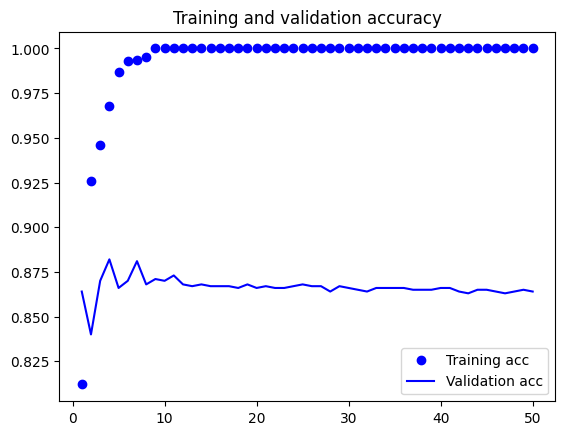

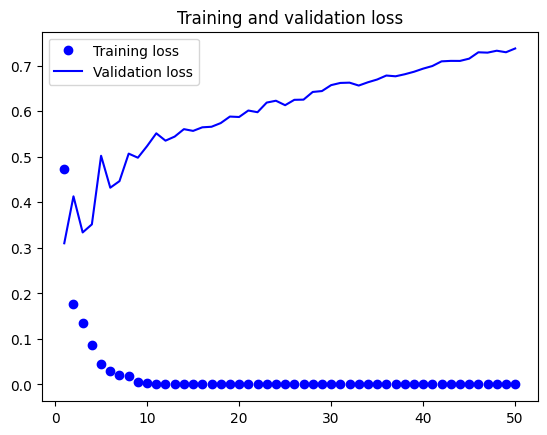

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**As a result of learning, the training accuracy converges to 1. In other words, the model was overfitted.**

> ### (50pts) Improve the baseline model
* Try at least three strategies to improve the validation performance of the baseline model.
* You should examine that the performance is indeed improved as you employ your strategies. In other words, you should show that (accuracy with strategy 1 <= accuracy with strategy 1 and 2 <= accuracy with strategy 1, 2, and 3).

>> ### (15pts) Trial 1: something

In [ ]:
# Trial1: image augmentation

from tensorflow.keras.applications import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

conv_base1 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# model training
model1 = models.Sequential()
model1.add(conv_base1)
model1.add(layers.Flatten())
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dense(2, activation='softmax'))
model1.summary()

conv_base1.trainable = False

model1.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])

# Image augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(128,128),
                                                    batch_size=20,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(128,128),
                                                        batch_size=20,
                                                        class_mode='categorical')

history = model1.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_data=validation_generator,
                              validation_steps=50)

model1.save('cats_and_dogs_small_2_aug.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 16812610 (64.14 MB)
Trainable params: 16812610 (64.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


<ipython-input-9-72419190a720>:45: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model1.fit_generator(train_generator,


Epoch 1/50
100/100 [==============================] - 20s 185ms/step - loss: 0.6285 - acc: 0.7320 - val_loss: 0.3151 - val_acc: 0.8600
Epoch 2/50
100/100 [==============================] - 18s 179ms/step - loss: 0.4265 - acc: 0.8030 - val_loss: 0.3131 - val_acc: 0.8540
Epoch 3/50
100/100 [==============================] - 20s 203ms/step - loss: 0.3805 - acc: 0.8180 - val_loss: 0.3245 - val_acc: 0.8510
Epoch 4/50
100/100 [==============================] - 18s 182ms/step - loss: 0.3788 - acc: 0.8350 - val_loss: 0.3191 - val_acc: 0.8440
Epoch 5/50
100/100 [==============================] - 18s 178ms/step - loss: 0.3587 - acc: 0.8345 - val_loss: 0.3011 - val_acc: 0.8610
Epoch 6/50
100/100 [==============================] - 18s 182ms/step - loss: 0.3422 - acc: 0.8445 - val_loss: 0.3697 - val_acc: 0.8430
Epoch 7/50
100/100 [==============================] - 18s 178ms/step - loss: 0.3674 - acc: 0.8225 - val_loss: 0.2773 - val_acc: 0.8760
Epoch 8/50
100/100 [==============================] - 1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


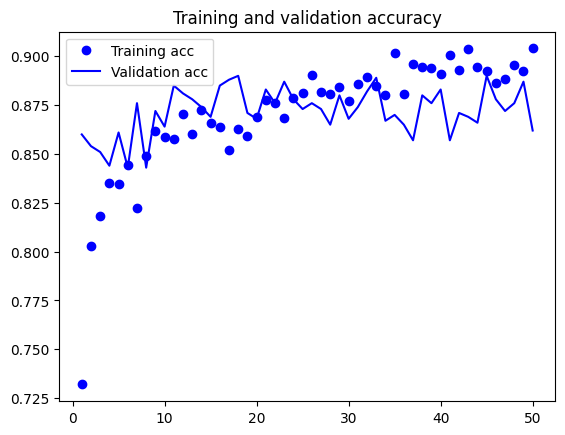

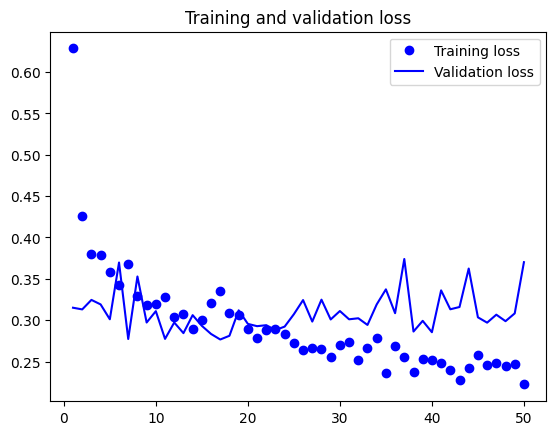

In [ ]:
# Trial1 performance plot
import matplotlib.pyplot as plt

acc1 = history.history['acc']
val_acc1 = history.history['val_acc']
loss1 = history.history['loss']
val_loss1 = history.history['val_loss']

epochs = range(1, len(acc1) + 1)

plt.plot(epochs, acc1, 'bo', label='Training acc')
plt.plot(epochs, val_acc1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss1, 'bo', label='Training loss')
plt.plot(epochs, val_loss1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Unlike the fact that validation loss gradually increases as epoch increases in the base model, in the model after the first trial, the loss is generally distributed in a section between 0.25 and 0.35 regardless of epoch.**

**Also, the degree of overfitting is weaker than before.**

>> ### (15pts) Trial 2: trial1 + something

In [ ]:
# Trial2: Dropout 0.3 + Augmentation
from tensorflow.keras.applications import VGG16

conv_base2 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(128, 128, 3))
conv_base2.summary()


model2 = models.Sequential()
model2.add(conv_base2)
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.3))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(2, activation='softmax'))
model2.summary()

conv_base2.trainable = False

model2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])

# Image augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(128,128),
                                                    batch_size=20,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(128,128),
                                                        batch_size=20,
                                                        class_mode='categorical')

history = model2.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_data=validation_generator,
                              validation_steps=50)

model2.save('cats_and_dogs_small_2_dropout.h5')

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


<ipython-input-11-b191056c96f9>:46: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model2.fit_generator(train_generator,


Epoch 1/50
100/100 [==============================] - 23s 202ms/step - loss: 0.5986 - acc: 0.7190 - val_loss: 0.3393 - val_acc: 0.8440
Epoch 2/50
100/100 [==============================] - 18s 184ms/step - loss: 0.4488 - acc: 0.7850 - val_loss: 0.3223 - val_acc: 0.8490
Epoch 3/50
100/100 [==============================] - 18s 178ms/step - loss: 0.4252 - acc: 0.7975 - val_loss: 0.3407 - val_acc: 0.8450
Epoch 4/50
100/100 [==============================] - 18s 182ms/step - loss: 0.4054 - acc: 0.8105 - val_loss: 0.3300 - val_acc: 0.8440
Epoch 5/50
100/100 [==============================] - 18s 178ms/step - loss: 0.3712 - acc: 0.8325 - val_loss: 0.2963 - val_acc: 0.8590
Epoch 6/50
100/100 [==============================] - 20s 200ms/step - loss: 0.3627 - acc: 0.8310 - val_loss: 0.2851 - val_acc: 0.8740
Epoch 7/50
100/100 [==============================] - 18s 178ms/step - loss: 0.3760 - acc: 0.8280 - val_loss: 0.3008 - val_acc: 0.8600
Epoch 8/50
100/100 [==============================] - 1

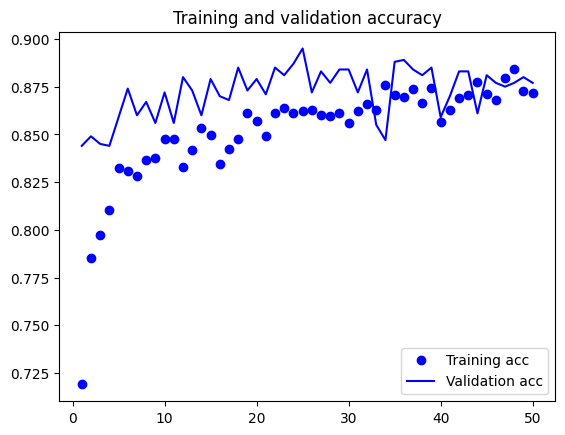

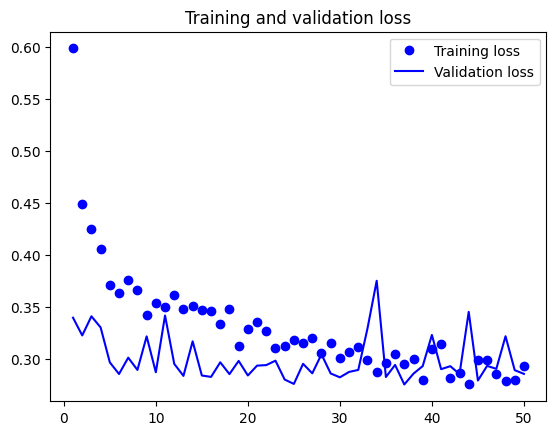

In [ ]:
# Trial2 performance plot
import matplotlib.pyplot as plt

acc2 = history.history['acc']
val_acc2 = history.history['val_acc']
loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

epochs = range(1, len(acc2) + 1)

plt.plot(epochs, acc2, 'bo', label='Training acc')
plt.plot(epochs, val_acc2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss2, 'bo', label='Training loss')
plt.plot(epochs, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

 **After going through the second trial, the distribution of validation tends to be the same as the distribution of training. After 20 epochs, the change in the trend of validation and loss decreases.**

>> ### (20pts) Trial 3: trial1 + trial2 + something

In [ ]:
for layer in conv_base2.layers:
    print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x79fc827a4f70> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79fc827a5300> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79fce018cb50> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x79fc827a4ca0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79fc827a4dc0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79fc82719c30> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x79fc827a5660> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79fce0172530> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79fc94b1b2e0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79fce0144f40> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x79fc8273ae00> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x79fc8277cb50> False
<keras.src.layers.convolutional.conv2d.Conv2D ob

In [ ]:
conv_base2.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
# Trial3: Fine tuning + Dropout 0.3 + Augmentation

from tensorflow.keras.applications import VGG16

model3= models.Sequential()
model3.add(conv_base2)
model3.add(layers.Flatten())
model3.add(layers.Dropout(0.3))
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(2, activation='softmax'))

conv_base2.trainable = False

model3.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc'])

conv_base2.trainable = True

set_trainable = False
for layer in conv_base2.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

# Image augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(128,128),
                                                    batch_size=20,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(128,128),
                                                        batch_size=20,
                                                        class_mode='categorical')

history = model3.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_data=validation_generator,
                              validation_steps=50)

model3.save('cats_and_dogs_small_2_finetune.h5')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


<ipython-input-18-9a1570be6141>:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model3.fit_generator(train_generator,


Epoch 1/50
100/100 [==============================] - 19s 181ms/step - loss: 0.5921 - acc: 0.7205 - val_loss: 0.3258 - val_acc: 0.8560
Epoch 2/50
100/100 [==============================] - 20s 203ms/step - loss: 0.4182 - acc: 0.8090 - val_loss: 0.3760 - val_acc: 0.8380
Epoch 3/50
100/100 [==============================] - 18s 179ms/step - loss: 0.4143 - acc: 0.8055 - val_loss: 0.3128 - val_acc: 0.8620
Epoch 4/50
100/100 [==============================] - 18s 184ms/step - loss: 0.4049 - acc: 0.8175 - val_loss: 0.3121 - val_acc: 0.8710
Epoch 5/50
100/100 [==============================] - 19s 185ms/step - loss: 0.3830 - acc: 0.8255 - val_loss: 0.3449 - val_acc: 0.8470
Epoch 6/50
100/100 [==============================] - 18s 179ms/step - loss: 0.3800 - acc: 0.8260 - val_loss: 0.3143 - val_acc: 0.8710
Epoch 7/50
100/100 [==============================] - 19s 188ms/step - loss: 0.3669 - acc: 0.8395 - val_loss: 0.3367 - val_acc: 0.8660
Epoch 8/50
100/100 [==============================] - 1

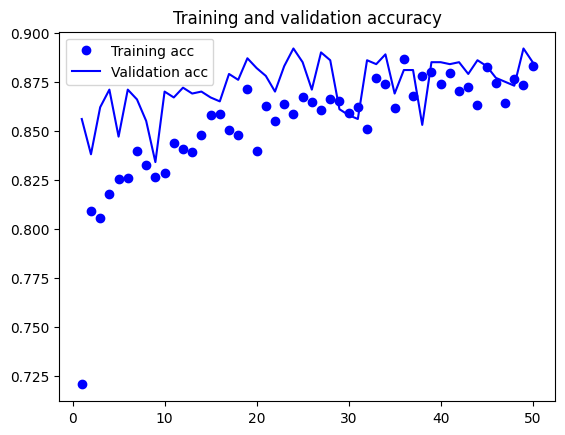

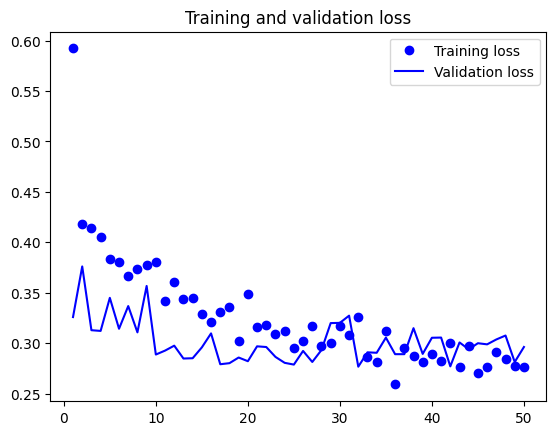

In [ ]:
# Trial3 performance plot
import matplotlib.pyplot as plt

acc3 = history.history['acc']
val_acc3 = history.history['val_acc']
loss3 = history.history['loss']
val_loss3 = history.history['val_loss']

epochs = range(1, len(acc3) + 1)

plt.plot(epochs, acc3, 'bo', label='Training acc')
plt.plot(epochs, val_acc3, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss3, 'bo', label='Training loss')
plt.plot(epochs, val_loss3, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**The accuracy and loss distributions of training and validation are more similar. Generalization seems to be working well.**

> ### (10pts) Compare the final performance of your models on the test dataset
  * Examine the final performance of the baseline, trial1, trial2, and trial3 models.
  * Verify the performance is improved as you apply some regularization methods. If not, discuss why.


In [ ]:
import os
test_dir = os.path.join(dst_path, 'subset/test')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(128,128),
                                                  batch_size=20,
                                                  class_mode='categorical')

print("Baseline model evaluation:", model.evaluate(test_generator))
print("Trial 1 model evaluation:", model1.evaluate(test_generator))
print("Trial 2 model evaluation:", model2.evaluate(test_generator))
print("Trial 3 model evaluation:", model3.evaluate(test_generator))

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 3s 66ms/step - loss: 0.7714 - acc: 0.8600
Baseline model evaluation: [0.771438717842102, 0.8600000143051147]
50/50 [==============================] - 3s 63ms/step - loss: 0.3870 - acc: 0.8530
Trial 1 model evaluation: [0.3869893550872803, 0.8529999852180481]
50/50 [==============================] - 3s 59ms/step - loss: 0.2900 - acc: 0.8740
Trial 2 model evaluation: [0.28996098041534424, 0.8740000128746033]
50/50 [==============================] - 3s 58ms/step - loss: 0.2965 - acc: 0.8800
Trial 3 model evaluation: [0.2964727580547333, 0.8799999952316284]


The 3 trials improved the model performance: Data augmentation, Dropout and Fine tuning.

The original model showed especially accurate score(1.0) in training but the accuracy was bad in validation, which implies overfitting.

To overcome it, firstly the data augmentation was used. The augmentation decreased accuracy from 0.8600 to 0.8530 but it decreased loss from 0.7714 to 0.3870

Secondly, dropout with 0.3 probability was used. Dropout increased accuracy and decreased loss than first trial.

Last trial was fine tuning. The fine tuning for block5_conv1 layer to be trainable resulted in increased accuracy.

As a result, we can find that regularization methods indeed lead to improved model performance.